In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')

In [3]:
from sensorcnn.visualization.examples import *
from sensorcnn.dataset.examples import *

## Load examples in Pandas

In [4]:
all_samples = {}
for filename in csv_file_iterator("/data"):
    samples = load_from_csv(filename)
    all_samples[filename] = samples

/Users/mostafa/Conda/envs/muvr_ml/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
sample1 = all_samples["/data/arms_0A5E8ACF-34B1-49BC-90B9-1F4DE16A9E10.csv"]

#### Add a column to the dataframe for setup data and label only a the first time window of each excercise e.g. 1 second as setup for this excercise

In [6]:
def set_setup_column(df, start=0, end=50):
    df['setup_label'] = 0
    n = 0
    for i, (s, is_excercise) in enumerate(zip(df[['label']].values, df['label'].notnull())):
        if is_excercise:
            n += 1
            if start <= n <= end:
                df.loc[i,'setup_label']= "setup_%s" % s[0]

        else:
            n = 0

#### convert all NaNs into 0 and all labeled into 1 just for plotting

In [7]:
def to_numeric(df):
    return df.fillna(0).replace(".*", 1, regex=True)

In [8]:
sample1['label'].value_counts()

lateral-raise        1824
triceps-extension    1621
biceps-curl          1619
Name: label, dtype: int64

In [9]:
to_numeric(sample1)['label'].value_counts()

0    7920
1    5064
Name: label, dtype: int64

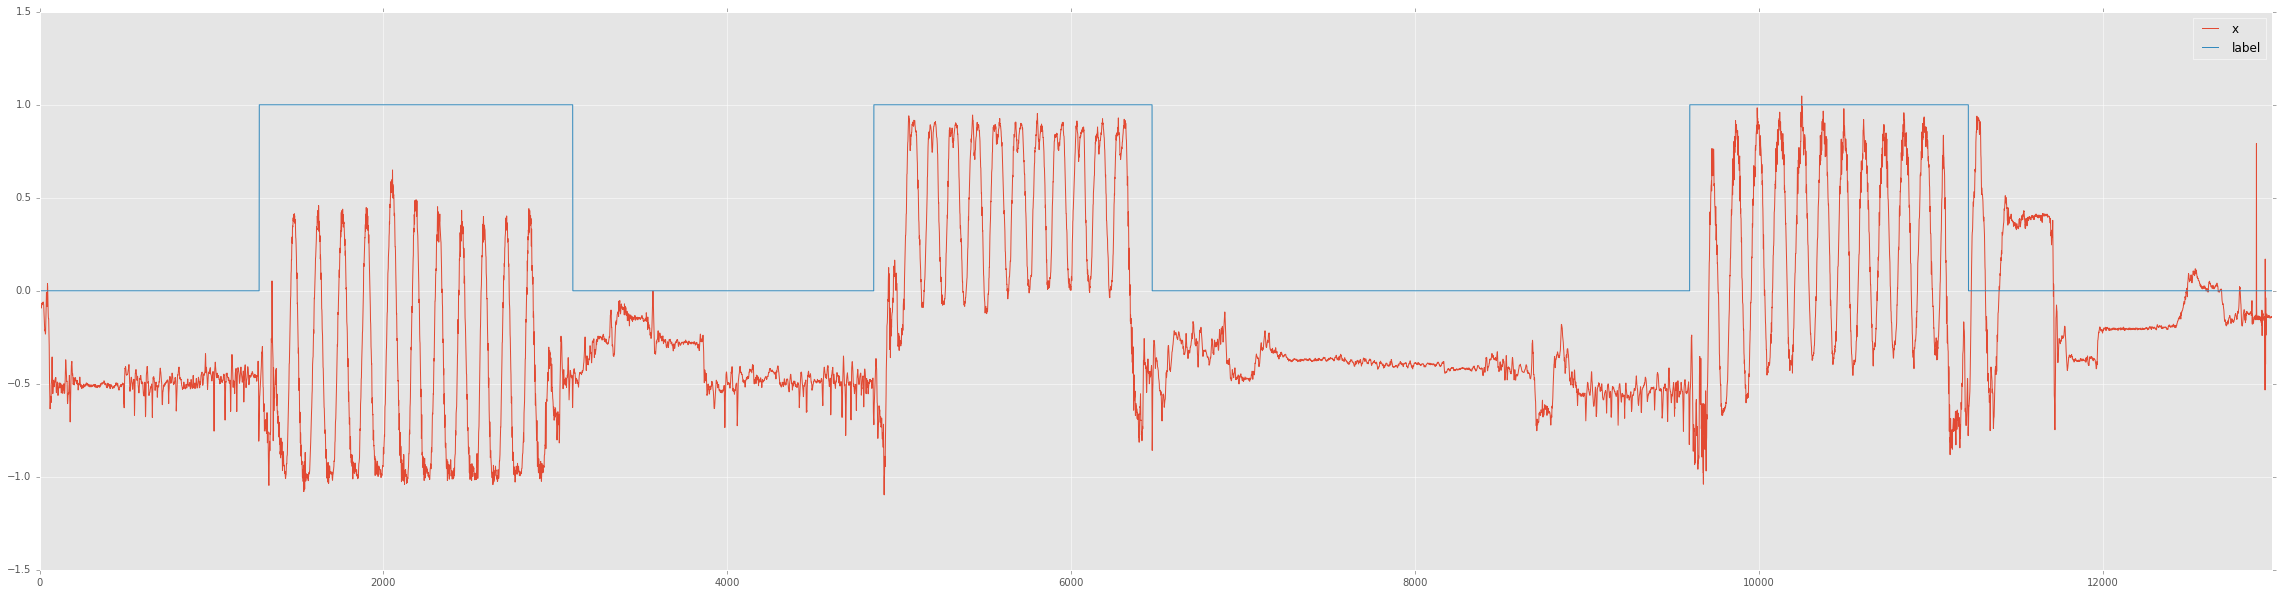

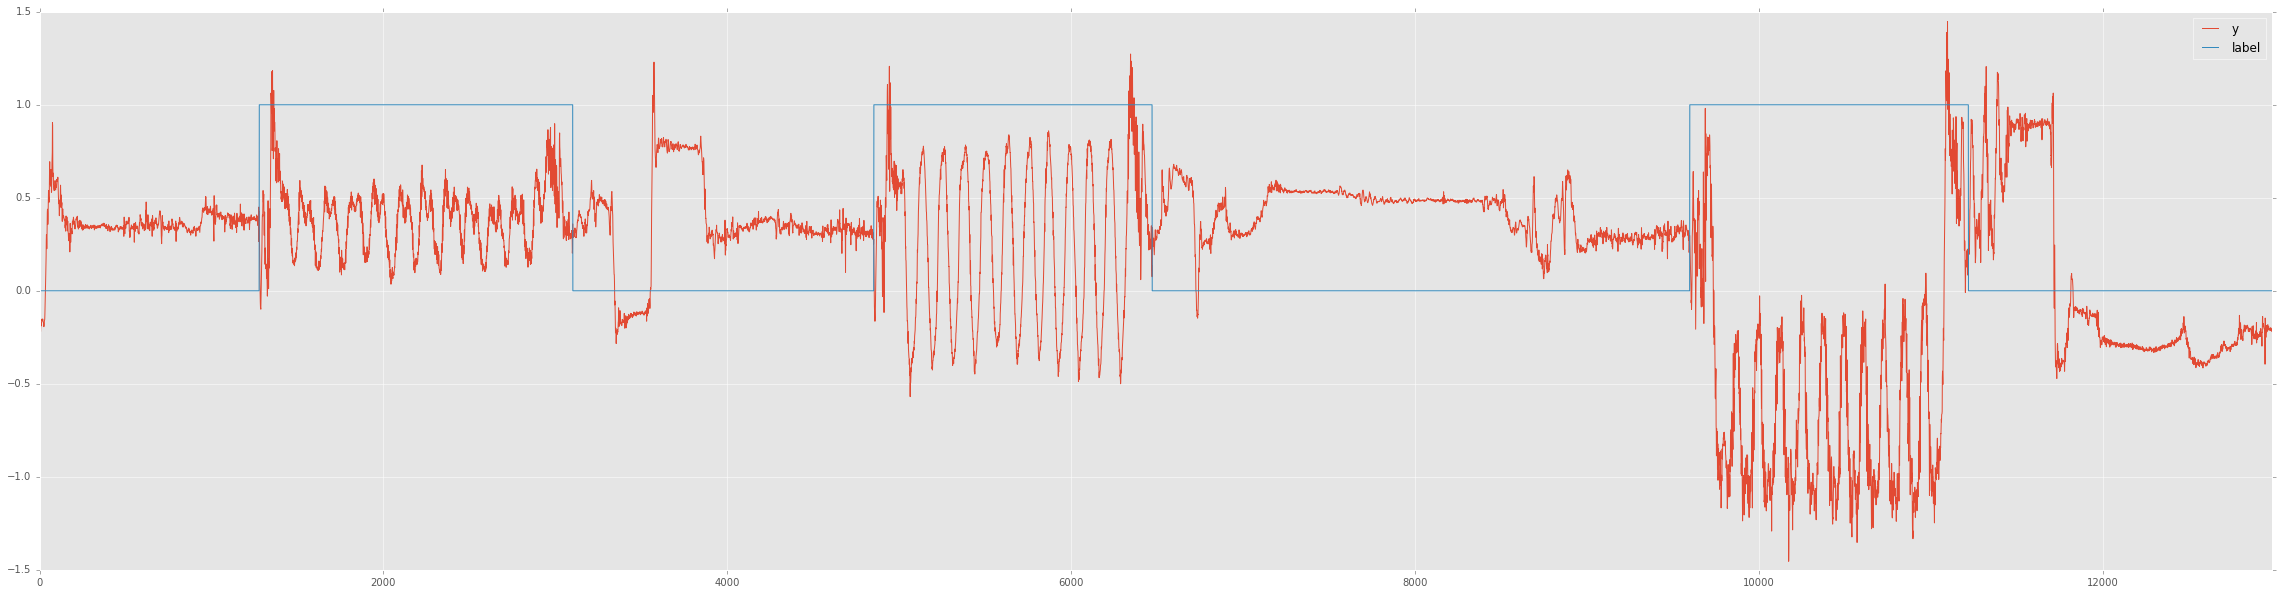

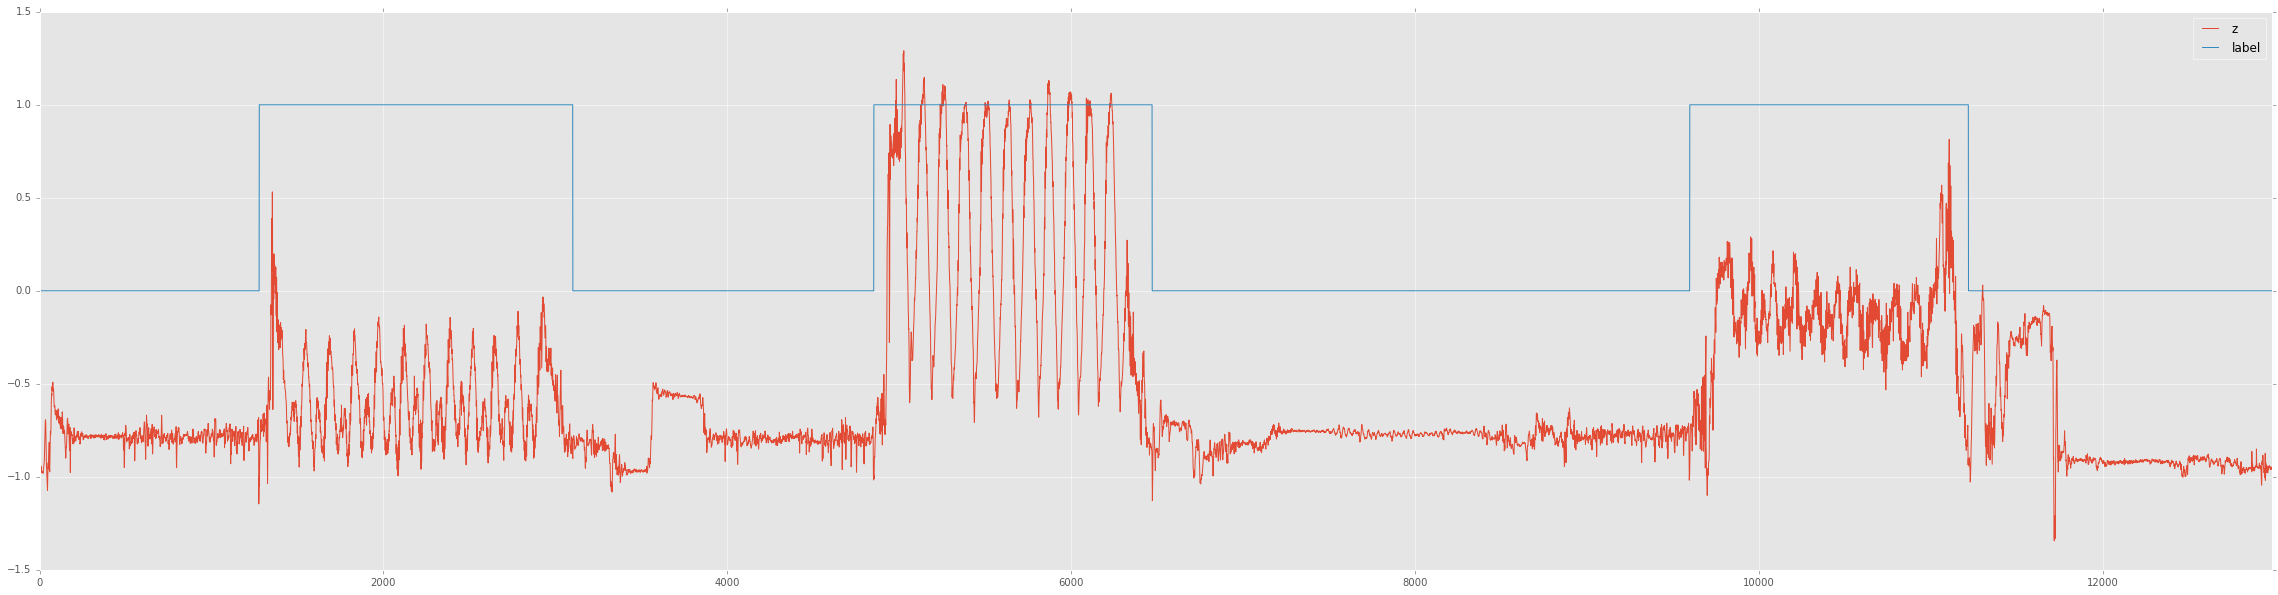

In [10]:
to_numeric(sample1)[['x', 'label']].plot(figsize=(40,10), style='-')
to_numeric(sample1)[['y', 'label']].plot(figsize=(40,10), style='-')
to_numeric(sample1)[['z', 'label']].plot(figsize=(40,10), style='-')

In [11]:
set_setup_column(sample1, start=0, end=50)

In [12]:
sample1['setup_label'].value_counts()

0                          12834
setup_triceps-extension       50
setup_biceps-curl             50
setup_lateral-raise           50
Name: setup_label, dtype: int64

In [13]:
to_numeric(sample1)['setup_label'].value_counts()

0    12834
1      150
Name: setup_label, dtype: int64

In [14]:
150 * (12834/150)

12834.0

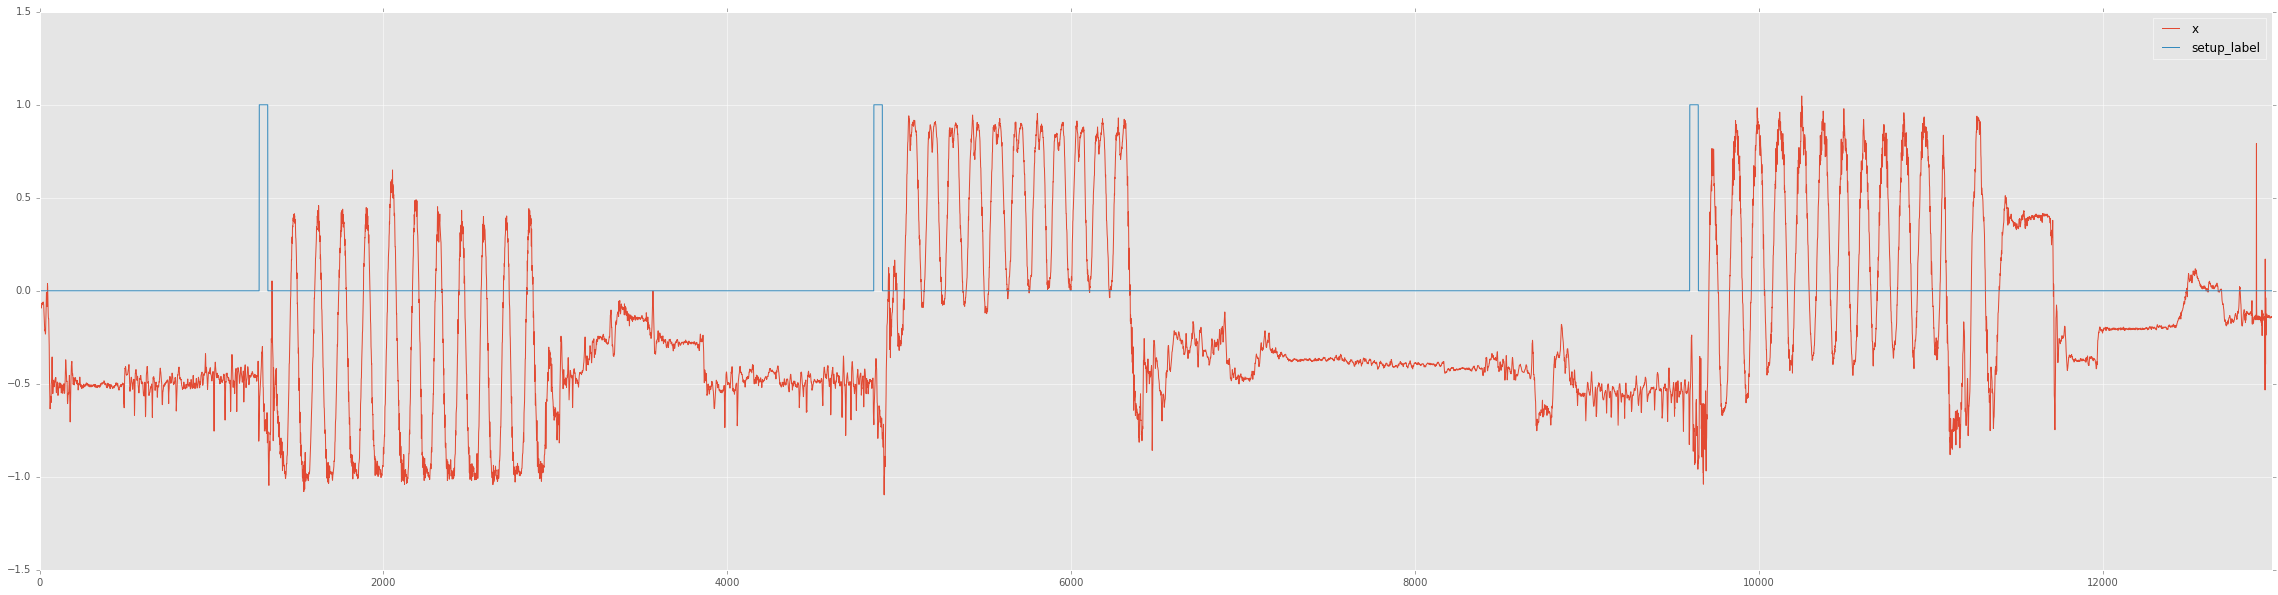

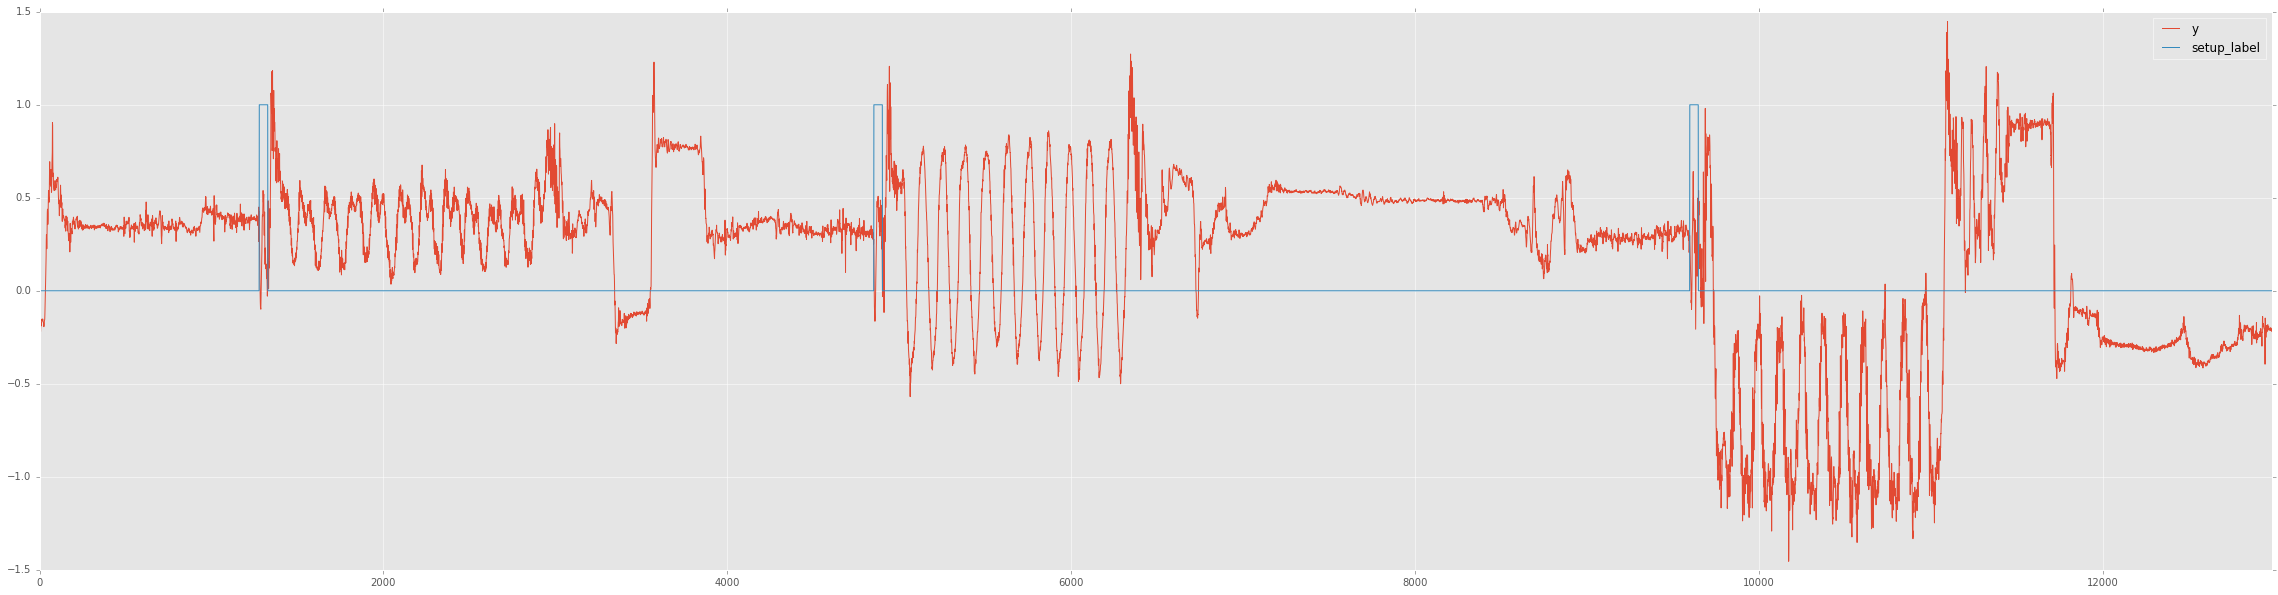

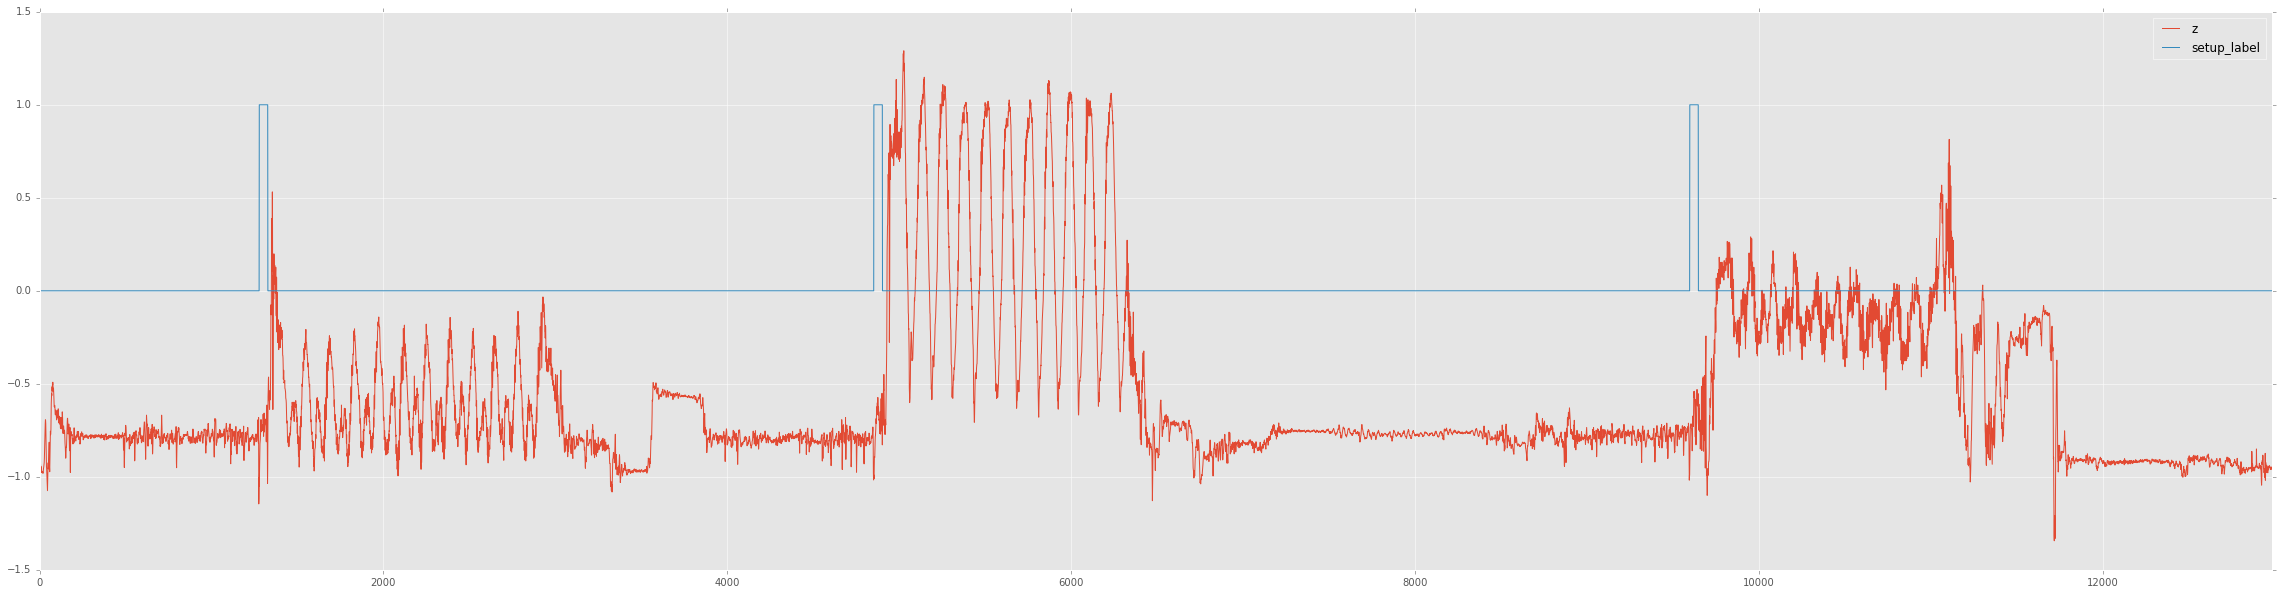

In [15]:
to_numeric(sample1)[['x', 'setup_label']].plot(figsize=(40,10), style='-')
to_numeric(sample1)[['y', 'setup_label']].plot(figsize=(40,10), style='-')
to_numeric(sample1)[['z', 'setup_label']].plot(figsize=(40,10), style='-')

### Labeling 6 setup exercises

#### map similar labels labels to the same label

In [16]:
def map_labels(label):
    return labels_mapping.get(label)

In [17]:
for s in all_samples.values():
    s['label'] = s['label'].map(map_labels)

#### add the setup column

In [18]:
print(len(all_samples))
for i, s in enumerate(all_samples.values()):
    set_setup_column(s, start=0, end=50)
    sys.stdout.write("%s "% i)

174
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 

#### merge all dataframes

In [19]:
from functools import reduce
all_samples_df = reduce(lambda x, y: x.append(y), all_samples.values())

In [21]:
all_samples_df['label'].value_counts()

biceps-curl             333881
lateral-raise           243789
triceps-extension       239648
dumbbell-chest-press     91392
rope-tricep-pushdown     13736
push-up                   4063
Name: label, dtype: int64

In [22]:
all_samples_df['setup_label'].value_counts()

0                             6533668
setup_biceps-curl                8400
setup_triceps-extension          6200
setup_lateral-raise              6100
setup_dumbbell-chest-press       2150
setup_rope-tricep-pushdown        450
setup_push-up                     150
Name: setup_label, dtype: int64

### Set targets

In [23]:
setup_labels = ["setup_%s" % l for l in labels]
label_idx_dict = {l : i for i, l in enumerate(setup_labels)}
label_to_idx = lambda x: label_idx_dict.get(x, 0)
all_samples_df['target'] = all_samples_df['setup_label'].map(label_to_idx)

In [24]:
all_samples_df['target'].value_counts()

0    6535818
2       8400
5       6200
1       6100
3        450
4        150
Name: target, dtype: int64

### Extract features and targets in numpy matrix

In [25]:
samples = all_samples_df[['x', 'y', 'z']].as_matrix()
positive_targets = all_samples_df[all_samples_df['target'] > 0]
negative_targets = all_samples_df[all_samples_df['target'] == 0]
targets = np.append(positive_targets[['target']].as_matrix(),
                    negative_targets[['target']].as_matrix(),
                    axis=0)

In [26]:
print(samples.shape)
print(targets.shape)

(6557118, 3)
(6557118, 1)


###  Examples augmentation - put each 50 sample into 1 50*3 sample

In [27]:
def augment_examples(X, Y, new_sample_size=50, label_merge=np.average):
    """"""
    assert X.shape[0] == Y.shape[0], "X and Y lengthes don't match"
    n_samples = X.shape[0]
    n_features = X.shape[1]
    n_labels = Y.shape[1]
    end = n_samples - (n_samples % new_sample_size)
    new_X = X[:end, :].reshape((int(end/new_sample_size), int(n_features*new_sample_size)))
    ys = []
    for y in Y[:end, :].reshape((int(end/new_sample_size), int(n_labels*new_sample_size))):
        ys.append(label_merge(y.reshape((new_sample_size, n_labels)), axis=0))

    new_Y = np.array(ys).astype(int)
    return new_X, new_Y

In [28]:
X, y = augment_examples(samples, targets)
print(X.shape)
print(y.shape)

(131142, 150)
(131142, 1)


### Encode labels

In [29]:
Y = np.zeros((y.shape[0], 6))
iy = np.array([[i,y] for (i,y) in enumerate(y) if y > 0])
Y[iy[:,0], iy[:,1]] = 1
print(y.shape)
print(Y.shape)
(y > 0).sum() == Y.sum()

(131142, 1)
(131142, 6)


True

### Balance data by multiblying the positive labels

In [31]:
def boost(x, n, partition):
    repeated = np.repeat(x[0:partition, :], n-1, axis=0)
    return np.append(x, repeated, axis=0)

In [32]:
n = int(len(y) / len(iy))
partition = len(iy)
new_X = boost(X, n, partition)
new_Y = boost(Y, n, partition)
print(new_X.shape)
print(new_Y.shape)

(261498, 150)
(261498, 6)


### Train MLP

In [33]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(new_X, new_Y, test_size=0.33, random_state=42)

In [34]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(input_dim=150, output_dim=64, init='uniform', activation='tanh'))
model.add(Dense(input_dim=64, output_dim=32, init='uniform', activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(input_dim=32, output_dim=6, init='uniform', activation='tanh'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=["accuracy"])

Using Theano backend.


In [ ]:
model.fit(X_train, Y_train, nb_epoch=30, batch_size=128)

Epoch 1/30
175203/175203 [==============================] - 2s - loss: 0.0670 - acc: 0.2270     
Epoch 2/30
175203/175203 [==============================] - 2s - loss: 0.0594 - acc: 0.2884     
Epoch 3/30
175203/175203 [==============================] - 2s - loss: 0.0539 - acc: 0.3349     
Epoch 4/30
 76032/175203 [============>.................] - ETA: 1s - loss: 0.0509 - acc: 0.3551

In [ ]:
train_score = model.evaluate(X_train, Y_train, batch_size=128)
test_score = model.evaluate(X_test, Y_test, batch_size=128)
print(train_score)
print(test_score)